In [111]:
import glob
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_curve, auc

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
SEED = 8455

In [4]:
cols_to_skip = ['raw_text', 'language']

In [5]:
df_html_data = pd.concat([pd.read_csv(csv, lineterminator='\n', usecols=lambda x: x not in cols_to_skip)
               for csv in glob.glob('../data/csv/*.csv')], ignore_index=True)
df_file_labels = pd.read_csv('../data/html_targets.csv')
df = df_html_data.merge(df_file_labels, left_on='filename', right_on='file')
df = df.drop(['file', 'filename'], axis=1)

In [6]:
stop_words = set(stopwords.words('english') + \
                 stopwords.words('french') + \
                 stopwords.words('german') + \
                 stopwords.words('spanish')
                )

In [7]:
lemmer = WordNetLemmatizer()
text_transformer = TfidfVectorizer(max_features=250, ngram_range=(1, 2))

In [8]:
df['title'] = df['title'].fillna('')
df['title'] = df['title'].map(lambda x: x.lower())
df['title'] = df['title'].map(lambda x: re.sub(r'[^\w\s]', '', x))
df['title'] = df['title'].map(lambda x: re.sub(r'\d+', '', x))
df['title'] = df['title'].map(lambda x: [lemmer.lemmatize(word) for word in x.split() if word not in stop_words])
df['title'] = df['title'].map(lambda x: ' '.join(x))

In [9]:
df_text = text_transformer.fit_transform(df['title'])

In [10]:
df_text = pd.DataFrame(df_text.toarray(), columns=text_transformer.get_feature_names_out())

In [11]:
df = df.join(df_text)

In [12]:
df = df.drop(['title'], axis=1)

In [13]:
X = df.drop(['sponsored'], axis=1)
y = df['sponsored']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

### RF Model

In [14]:
clf = RandomForestClassifier(class_weight='balanced',
                              criterion='entropy',
                              max_samples=0.9262414952228437,
                              min_samples_split=9,
                              n_estimators=289,
                              random_state=SEED)

In [15]:
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_samples=0.9262414952228437, min_samples_split=9,
                       n_estimators=289, random_state=8455)

In [35]:
rf_y_pred = clf.predict(X_test)

In [36]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     60946
           1       0.87      0.47      0.61      6459

    accuracy                           0.94     67405
   macro avg       0.91      0.73      0.79     67405
weighted avg       0.94      0.94      0.93     67405



In [25]:
sorted(zip(X.columns, clf.feature_importances_), key=lambda x: x[1] * -1)[:10]

[('num_scripts', 0.05375852587720081),
 ('num_links', 0.048443714125413075),
 ('num_tags', 0.04754793445104348),
 ('num_lines', 0.04704443191353387),
 ('num_digits', 0.046524732031565645),
 ('num_characters', 0.04470769652235222),
 ('num_words', 0.04149311052182512),
 ('num_unique_words', 0.04143942031601846),
 ('num_headers', 0.040975081618243175),
 ('num_images', 0.040516069192487805)]

In [37]:
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, rf_y_pred)

In [38]:
rf_roc_auc = auc(rf_fpr, rf_tpr)

### XGBoost

In [19]:
xgb = XGBClassifier(colsample_bytree=0.996270091604168, 
                    gamma=0.338776396380703,
                    learning_rate=0.301616719851245,
                    max_depth=8,
                    min_child_weight=6,
                    subsample=0.836850617,
                    random_state=SEED)

In [20]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.996270091604168, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.338776396380703, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.301616719851245, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=8, max_leaves=0, min_child_weight=6, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=8455, ...)

In [39]:
xgb_y_pred = xgb.predict(X_test)

In [40]:
print(classification_report(y_test, xgb_y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     60946
           1       0.85      0.32      0.46      6459

    accuracy                           0.93     67405
   macro avg       0.89      0.66      0.71     67405
weighted avg       0.92      0.93      0.91     67405



### CatBoost

In [21]:
catboost = CatBoostClassifier(depth=9,
                              learning_rate=0.400583844474974,
                              l2_leaf_reg=8,
                              iterations=392,
                              random_seed=SEED, 
                              silent=True)

In [22]:
catboost.fit(X_train, y_train)

In [41]:
catboost_y_pred = catboost.predict(X_test)

In [42]:
print(classification_report(y_test, catboost_y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     60946
           1       0.83      0.42      0.56      6459

    accuracy                           0.94     67405
   macro avg       0.89      0.70      0.76     67405
weighted avg       0.93      0.94      0.93     67405



### Chart

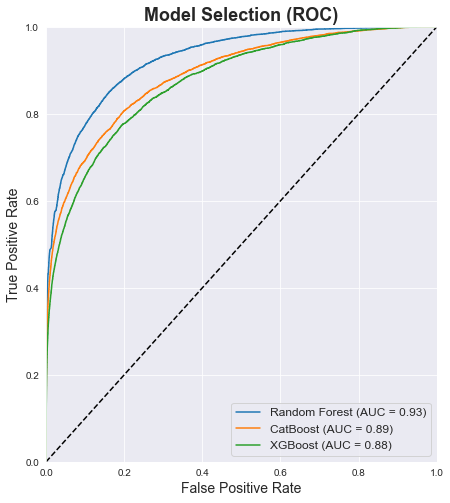

In [114]:
model_y_preds = {
    'Random Forest': clf,
    'CatBoost': catboost,
    'XGBoost': xgb
}

sns.set_style('darkgrid')
plt.title('Model Selection (ROC)', fontsize=18, fontweight='bold')
for model_name, model in model_y_preds.items():   
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f'{model_name} (AUC = {round(roc_auc, 2)})')
plt.legend(loc = 'lower right', fontsize=12)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.rcParams["figure.figsize"] = (7, 8)
plt.savefig('model_roc.svg', bbox_inches = 'tight')